In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import pickle
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import math
from underthesea import word_tokenize
from operator import itemgetter
from time import time
import warnings
import enchant
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv('ican_se_139k.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139452 entries, 0 to 139451
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   QuestionID  139452 non-null  object
 1   ImageURL    139452 non-null  object
 2   ImageOCR    139452 non-null  object
dtypes: object(3)
memory usage: 3.2+ MB


In [11]:
df.head()

,QuestionID,ImageURL,ImageOCR
0,221207ad-45f4-11ed-813f-a6869563e5be,https://s3.icankid.io/uploads/question/20bdf49...,B-TƯLUÂN\n2.12. Biểu diễn miền nghiệm của bất ...
1,59318f0d-45f4-11ed-813f-a6869563e5be,https://s3.icankid.io/uploads/question/57781e2...,Câu 1: Học sinh chọn 1 trong 2 chủ đề sau?\nCh...
2,662de52e-45f4-11ed-813f-a6869563e5be,https://s3.icankid.io/uploads/question/651bc95...,3. Một cái bục hình lăng trụ đứng có kích thướ...
3,d94d655d-45f3-11ed-813f-a6869563e5be,https://s3.icankid.io/uploads/question/d80b6bb...,a) \( A=1+2+2^{2}+\ldots+2^{4} \) và \( B=2^{5...
4,00c4bb8a-45e5-11ed-8355-e24590ef346b,https://s3.icankid.io/uploads/question/ff999a3...,"Trong cà năm, trung binh mói thâng cha hâ đợ s..."


In [12]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
    #xoá khoảng trắng ở đầu và cuối mỗi câu
    text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [29]:
check_dup = df['ImageOCR'][df['ImageOCR'].duplicated()]

df = df.drop(check_dup.index).reset_index(drop = True)
df.shape

(133888, 3)

In [30]:
t0 = time()

df['clean_question'] = df['ImageOCR'].map(lambda x: clean_function(x))
print('Cleaning dataset took {:.2f} minutes.'.format((time() - t0) / 60))

Cleaning dataset took 18.57 minutes.


In [31]:
df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [32]:
df.head()

,QuestionID,ImageURL,ImageOCR,clean_question,char_count_question,word_count_question,average_word_length_question
0,221207ad-45f4-11ed-813f-a6869563e5be,https://s3.icankid.io/uploads/question/20bdf49...,B-TƯLUÂN\n2.12. Biểu diễn miền nghiệm của bất ...,b-tưluân 2.12 . biểu_diễn miền nghiệm của bất_...,142,35,4.057143
1,59318f0d-45f4-11ed-813f-a6869563e5be,https://s3.icankid.io/uploads/question/57781e2...,Câu 1: Học sinh chọn 1 trong 2 chủ đề sau?\nCh...,câu 1 : học_sinh chọn 1 trong 2 chủ_đề sau ? c...,338,66,5.121212
2,662de52e-45f4-11ed-813f-a6869563e5be,https://s3.icankid.io/uploads/question/651bc95...,3. Một cái bục hình lăng trụ đứng có kích thướ...,3 . một cái bục hình_lăng_trụ đứng có kích_thư...,183,39,4.692308
3,d94d655d-45f3-11ed-813f-a6869563e5be,https://s3.icankid.io/uploads/question/d80b6bb...,a) \( A=1+2+2^{2}+\ldots+2^{4} \) và \( B=2^{5...,a ) \ ( a = 1 + 2 + 2 ^ { 2 } + \ ldots + 2 ^_...,84,37,2.270270
4,00c4bb8a-45e5-11ed-8355-e24590ef346b,https://s3.icankid.io/uploads/question/ff999a3...,"Trong cà năm, trung binh mói thâng cha hâ đợ s...","trong cà năm , trung_binh mói thâng cha hâ đợ ...",77,20,3.850000


In [36]:
d = enchant.Dict('en_US')
d.check(df.iloc[1]['ImageOCR'])

False

In [39]:
df['en_language'] = df['ImageOCR'].map(lambda x: 1 if d.check(x) == True else 0)

In [41]:
df['en_language'].value_counts()

0    133883
1         5
Name: en_language, dtype: int64

In [42]:
df.loc[df['en_language'] == 1]

,QuestionID,ImageURL,ImageOCR,clean_question,char_count_question,word_count_question,average_word_length_question,en_language
11220,60cc24ef-d06a-11ec-9ee3-cac24781fafe,https://s3.icankid.io/uploads/question/5fdd1d4...,),),1,1,1.0,1
38890,a5761a1a-b4b6-11ec-89c4-920026c7b18d,https://s3.icankid.io/uploads/question/a49330c...,1,1,1,1,1.0,1
39030,1bd012b6-b557-11ec-95b4-9ad828188308,https://s3.icankid.io/uploads/question/1b60223...,-,-,1,1,1.0,1
39883,fb2328cb-b556-11ec-95b4-9ad828188308,https://s3.icankid.io/uploads/question/f9658e4...,8,8,1,1,1.0,1
41203,c6ec4e2f-c237-11ec-9ee3-cac24781fafe,https://s3.icankid.io/uploads/question/c6551fa...,an,an,2,1,2.0,1


In [65]:
lst1 = df.loc[df['word_count_question'] <= 5]
lst1

,QuestionID,ImageURL,ImageOCR,clean_question,char_count_question,word_count_question,average_word_length_question,en_language
57,0ee78878-4577-11ed-8355-e24590ef346b,https://s3.icankid.io/uploads/question/0dcd335...,tHY RN +N,thy rn + n,10,4,2.500000,0
105,1bcb08a7-454a-11ed-8355-e24590ef346b,https://s3.icankid.io/uploads/question/1b37787...,\( 25 \cdot 99 \),\ ( 25_\_cdot 99_\ ),20,5,4.000000,0
232,463a33e1-4546-11ed-8355-e24590ef346b,https://s3.icankid.io/uploads/question/455af6d...,Chobaing s'thas,chobaing s'thas,15,2,7.500000,0
265,5295ab3e-453c-11ed-8355-e24590ef346b,https://s3.icankid.io/uploads/question/5201fe1...,Bai7: Cho hinh ve,bai7 : cho hinh ve,18,5,3.600000,0
347,6a873103-4526-11ed-8355-e24590ef346b,https://s3.icankid.io/uploads/question/69b8b5a...,7 futurebook,7 futurebook,12,2,6.000000,0
...,...,...,...,...,...,...,...,...
131743,0c19663a-4069-11ed-85e0-dab7ac5017e4,https://s3.icankid.io/uploads/question/0b4071f...,BAI TAP\n40,bai tap 40,10,3,3.333333,0
132073,a5178b38-4001-11ed-85e0-dab7ac5017e4,https://s3.icankid.io/uploads/question/a4846b4...,vì KNM .\nHinh 3,vì knm ._hinh 3,15,4,3.750000,0
132691,77ac5740-3eb4-11ed-b586-e2500f50eb64,https://s3.icankid.io/uploads/question/76e332f...,mince:,mince :,7,2,3.500000,0
133179,ae49f80c-3fda-11ed-b857-66683b71fc16,https://s3.icankid.io/uploads/question/ad562dc...,UYTIN-TAANTÅM-CHUYÊN NGMI,uytin-taantåm-chuyên ngmi,25,2,12.500000,0


In [ ]:
# ![alternatvie text](https://s3.icankid.io/uploads/question/0dcd3350-4577-11ed-afcb-abad28552b30)

In [66]:
# import webbrowser

# for url in lst1['ImageURL'][:3]:
#     webbrowser.open(url)

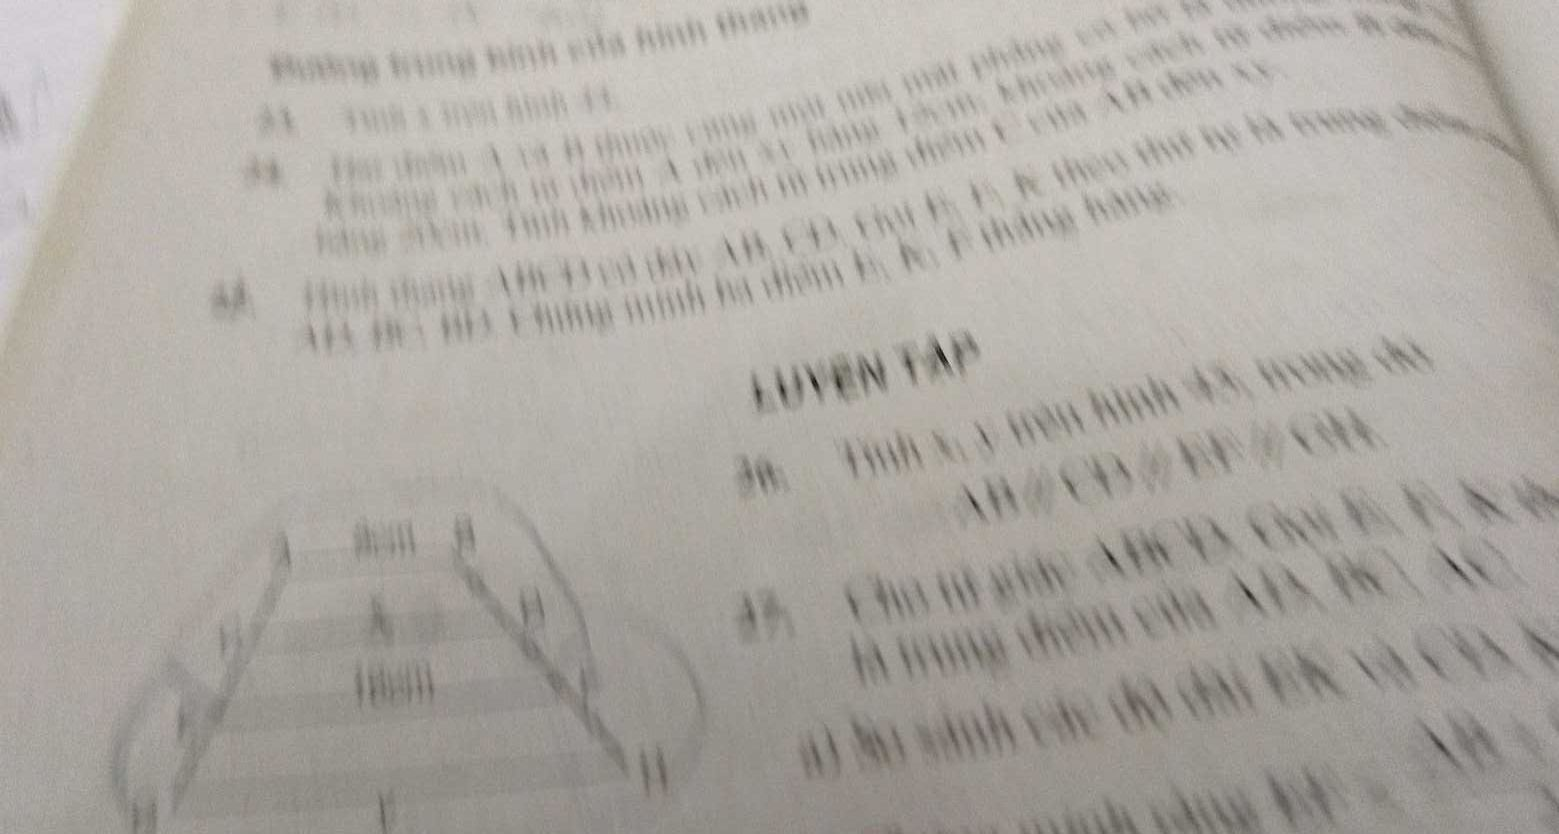

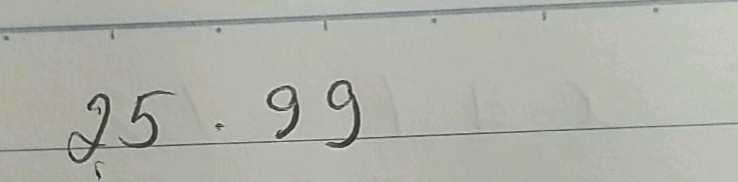

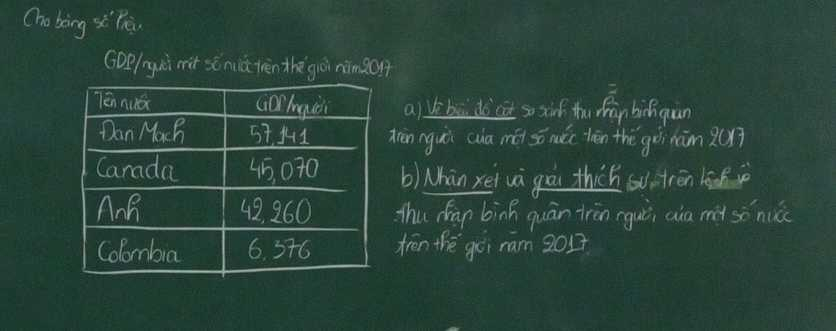

In [167]:
import requests
import IPython.display as Disp

for url in lst1['ImageURL'].values[0:3]:
    img = Disp.Image(requests.get(url).content)
    display(img)

In [165]:
from IPython.display import Image, display

In [168]:
import requests
from ipywidgets import Image

for b in lst1['ImageURL'].values[0:20]:
    image = Image(value=requests.get(b).content)
    display(image)

Image(value=b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x10\x0b\x0…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x02(ICC_PROFILE\x00…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00XExif\x00\x00MM\x00*\x…

Image(value=b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x10\x0b\x0…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x02(ICC_PROFILE\x00…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x10\x0b\x0…

Image(value=b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00XExif\x00\x00MM\x00*\x…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x02(ICC_PROFILE\x00…

Image(value=b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00XExif\x00\x00MM\x00*\x…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00XExif\x00\x00MM\x00*\x…

Image(value=b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00XExif\x00\x00MM\x00*\x…

Image(value=b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x02(ICC_PROFILE\x00…

Image(value=b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00XExif\x00\x00MM\x00*\x…

In [170]:
739/133888 * 100

0.5519538718929254